# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

'''
From data given, 
1. column named 'default', 'housing' and 'loan' is going to play active role on cusomers 
    comitting to a term plan that is going to put financial strain on an individual.

2. Given priority for above three columns removing 'unknown' rows from these three columsn. Numbers of unknowns are very in-significant compared to the rows that has valid data like yes or no.

3. Column named 'job' has lot many variants that can lead over fitting of a model and hence igonored it.

4. Columns named cpi, cci, employed etc are given less proority as that data is not going to play any active role on an individual to choose to either commit for a term loan or not.

'''

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV




In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.rename(columns={'emp.var.rate':'evr', 'cons.price.idx':'cpi', 'cons.conf.idx':'cci', 'euribor3m':'e3m', 'nr.employed':'employed'}, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          41188 non-null  int64  
 1   job          41188 non-null  object 
 2   marital      41188 non-null  object 
 3   education    41188 non-null  object 
 4   default      41188 non-null  object 
 5   housing      41188 non-null  object 
 6   loan         41188 non-null  object 
 7   contact      41188 non-null  object 
 8   month        41188 non-null  object 
 9   day_of_week  41188 non-null  object 
 10  duration     41188 non-null  int64  
 11  campaign     41188 non-null  int64  
 12  pdays        41188 non-null  int64  
 13  previous     41188 non-null  int64  
 14  poutcome     41188 non-null  object 
 15  evr          41188 non-null  float64
 16  cpi          41188 non-null  float64
 17  cci          41188 non-null  float64
 18  e3m          41188 non-null  float64
 19  empl

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be corected to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          41188 non-null  int64  
 1   job          41188 non-null  object 
 2   marital      41188 non-null  object 
 3   education    41188 non-null  object 
 4   default      41188 non-null  object 
 5   housing      41188 non-null  object 
 6   loan         41188 non-null  object 
 7   contact      41188 non-null  object 
 8   month        41188 non-null  object 
 9   day_of_week  41188 non-null  object 
 10  duration     41188 non-null  int64  
 11  campaign     41188 non-null  int64  
 12  pdays        41188 non-null  int64  
 13  previous     41188 non-null  int64  
 14  poutcome     41188 non-null  object 
 15  evr          41188 non-null  float64
 16  cpi          41188 non-null  float64
 17  cci          41188 non-null  float64
 18  e3m          41188 non-null  float64
 19  empl

In [7]:
sum(df.duplicated())

12

In [8]:
df.isna().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
evr            0
cpi            0
cci            0
e3m            0
employed       0
y              0
dtype: int64

In [9]:
df = df.drop_duplicates()

In [10]:
sum(df.duplicated())

0

In [11]:
df.describe()

,age,duration,campaign,pdays,previous,evr,cpi,cci,e3m,employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'campaign'}>],
       [<AxesSubplot:title={'center':'pdays'}>,
        <AxesSubplot:title={'center':'previous'}>,
        <AxesSubplot:title={'center':'evr'}>],
       [<AxesSubplot:title={'center':'cpi'}>,
        <AxesSubplot:title={'center':'cci'}>,
        <AxesSubplot:title={'center':'e3m'}>],
       [<AxesSubplot:title={'center':'employed'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

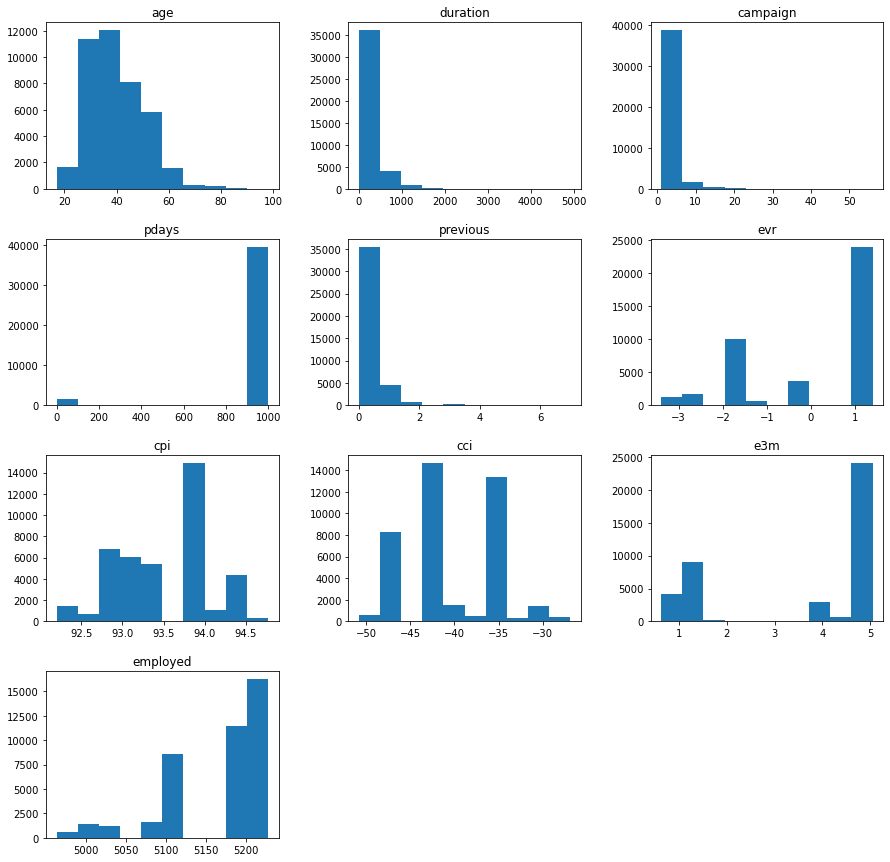

In [12]:
df.hist(figsize = (15,15), grid = False)

In [13]:
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10419,24921,12164,32577,21571,33938,26135,13767,8618,35551,36537


In [14]:
categoryList = df.select_dtypes("object").columns.tolist()
categoryList

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

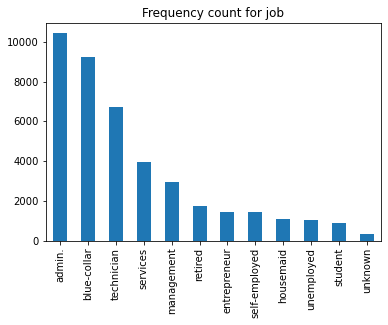

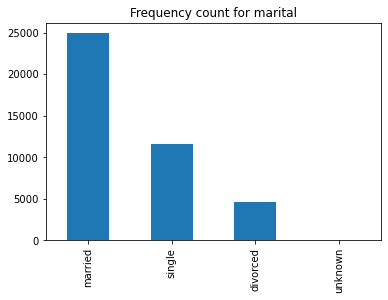

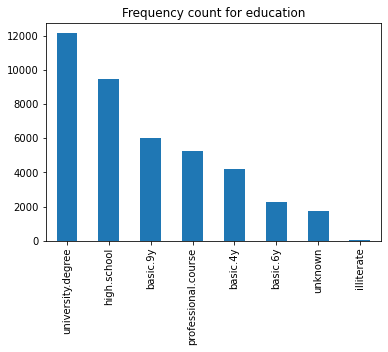

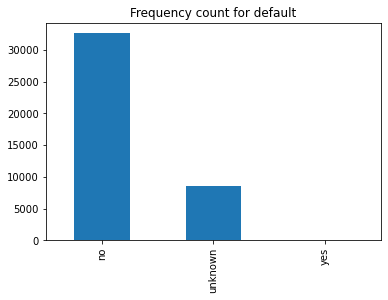

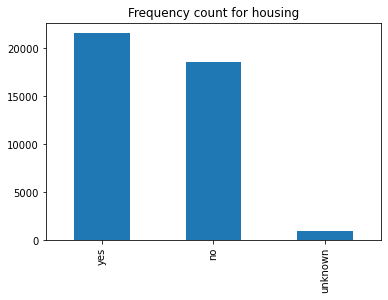

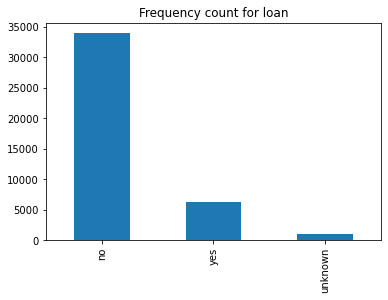

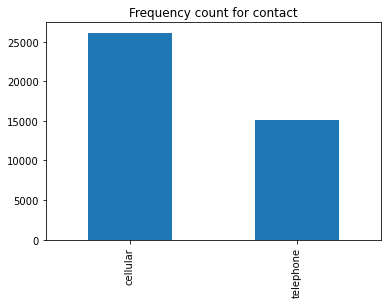

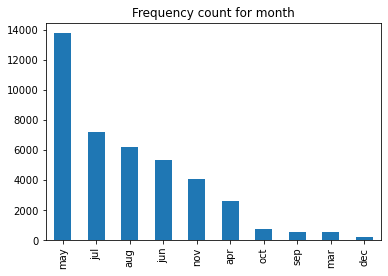

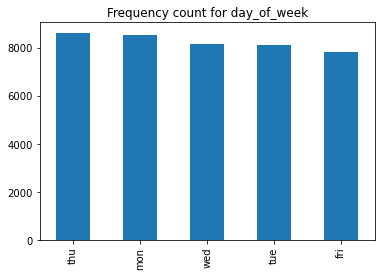

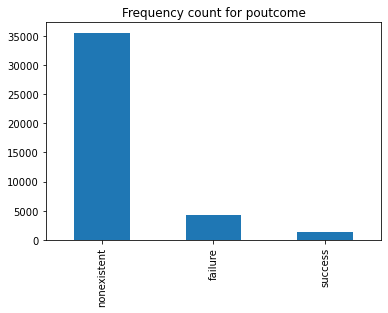

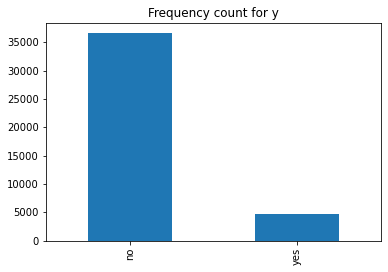

In [15]:
for category in categoryList:
    df[category].value_counts().plot(kind = 'bar', title = f"Frequency count for {category}")
    plt.show()

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [16]:
df['y'].value_counts(normalize= True).to_frame().style.format('{:.1%}')

,y
no,88.7%
yes,11.3%


<AxesSubplot:>

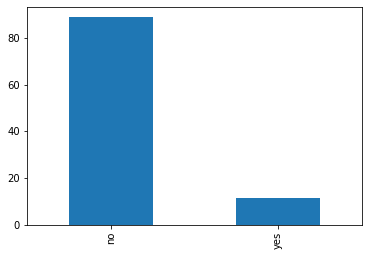

In [17]:
df['y'].value_counts(normalize= True).round(4).multiply(100).plot(kind = 'bar')

In [18]:
df['y'] = df['y'].replace({'yes': 1, 'no': 0})

In [19]:
df['y'].value_counts(normalize= True).to_frame().style.format('{:.1%}')

,y
0,88.7%
1,11.3%


In [20]:
df['y'].mean()

0.11266271614532737

In [21]:
df.groupby(['duration'])['y'].mean()

duration
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3631    1.0
3643    1.0
3785    0.0
4199    1.0
4918    0.0
Name: y, Length: 1544, dtype: float64

<AxesSubplot:title={'center':'Average # of contacts for same client'}, xlabel='duration'>

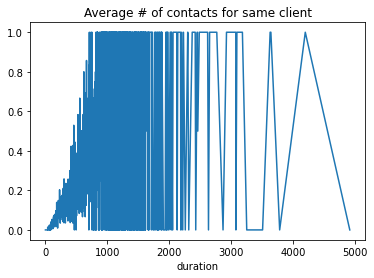

In [22]:
df.groupby(['duration'])['y'].mean().plot(kind = 'line', title = "Average # of contacts for same client")

<AxesSubplot:title={'center':'Average # of contacts for same client'}, xlabel='campaign'>

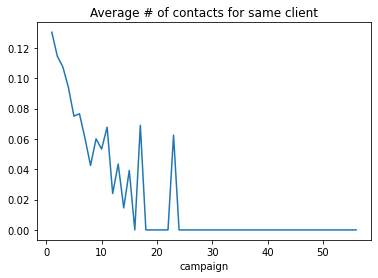

In [23]:
df.groupby(['campaign'])['y'].mean().plot(kind = 'line', title = "Average # of contacts for same client")

In [24]:
mly = df.groupby(['campaign'], as_index = False)['y'].mean()
mly.head()

,campaign,y
0,1,0.130373
1,2,0.114591
2,3,0.107491
3,4,0.093962
4,5,0.075047


In [26]:
dfm = df.drop(['marital','job','education','month','day_of_week','pdays','previous','poutcome','cpi','cci','evr','e3m','contact'], axis=1)


<AxesSubplot:>

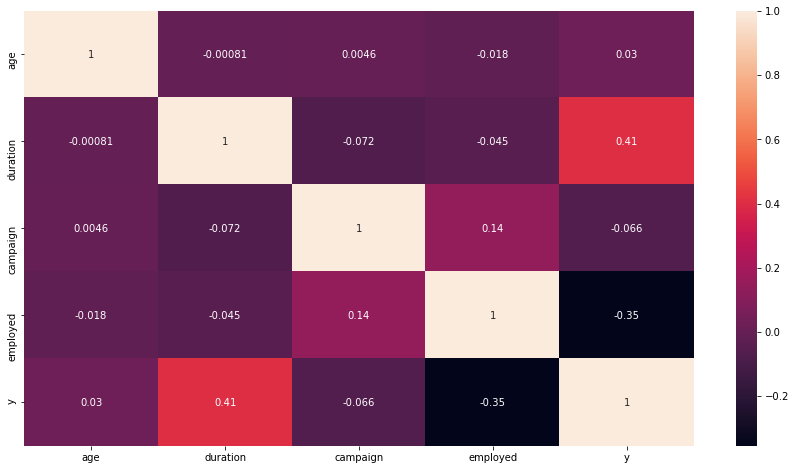

In [27]:
corrM = dfm.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corrM, annot = True)

In [28]:
countUnknown = (dfm == 'unknown').any(axis=1).sum()
print(countUnknown)

9359


In [29]:
dfm = dfm[~dfm[['loan', 'housing', 'default']].isin(['unknown']).any(axis=1)]

In [30]:
dfm['y'].mean()
dfm['loan'] = dfm['loan'].replace({'yes': 1, 'no': 0})
dfm['default'] = dfm['default'].replace({'yes': 1, 'no': 0})
dfm['housing'] = dfm['housing'].replace({'yes': 1, 'no': 0})

<AxesSubplot:>

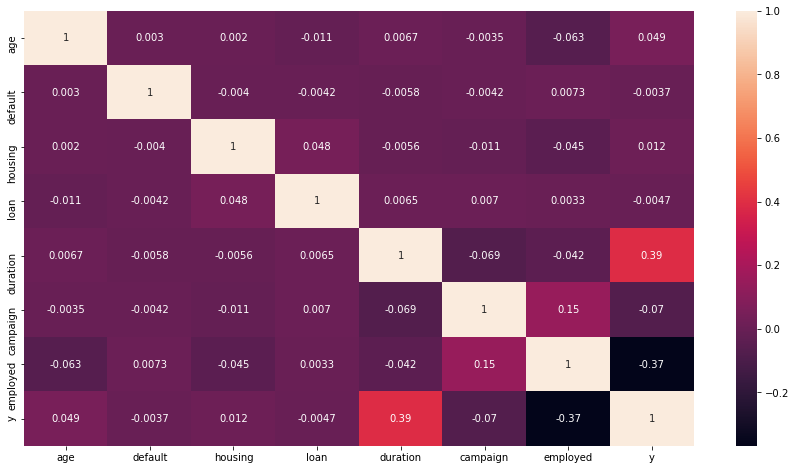

In [31]:
corrM = dfm.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corrM, annot = True)

<AxesSubplot:>

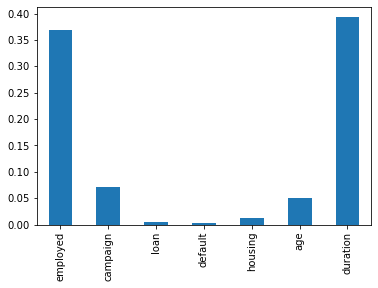

In [32]:
np.abs(corrM["y"].sort_values()[:-1]).plot(kind = "bar")

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [33]:
X = dfm.drop(columns = 'y')
y = dfm['y']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 2)

In [35]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("\n")
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

display(X_train.head())
display(y_train.head())

X_train:  (25453, 7)
y_train:  (25453,)


X_test:  (6364, 7)
y_test:  (6364,)


,age,default,housing,loan,duration,campaign,employed
36301,36,0,0,1,284,1,5076.2
8653,32,0,1,0,23,2,5228.1
21934,31,0,0,0,195,1,5228.1
17021,47,0,0,1,417,5,5228.1
30191,38,0,1,0,110,1,5099.1


36301    1
8653     0
21934    0
17021    0
30191    0
Name: y, dtype: int64

In [36]:
num_columns = X_train.select_dtypes(["int","float"]).columns
num_columns

Index(['age', 'default', 'housing', 'loan', 'duration', 'campaign',
       'employed'],
      dtype='object')

In [37]:
num_transformer = StandardScaler()
preprocessor = ColumnTransformer(transformers=[('num',num_transformer,num_columns)])

In [38]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['age', 'default', 'housing', 'loan', 'duration', 'campaign',
       'employed'],
      dtype='object'))])

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [39]:
pipeline = Pipeline(steps = [("preprocessor",preprocessor),("classifier",LogisticRegression())])

In [40]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'default', 'housing', 'loan', 'duration', 'campaign',
       'employed'],
      dtype='object'))])),
                ('classifier', LogisticRegression())])

In [41]:
pipeline.fit(X_train, y_train)
print(f"Train data accuracy: {pipeline.score(X_train, y_train):.2f}")
print(f"Test data accuracy: {pipeline.score(X_test, y_test):.2f}")

Train data accuracy: 0.89
Test data accuracy: 0.89


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [42]:
pipeline.named_steps["classifier"]

LogisticRegression()

In [43]:
lr_class = pipeline.named_steps["classifier"].classes_
lr_class

array([0, 1])

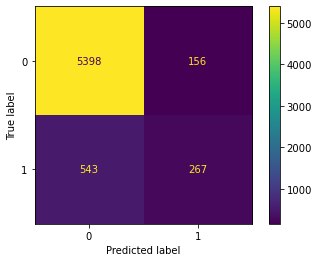

In [44]:
test_predictions = pipeline.predict(X_test)
cm = confusion_matrix(y_test, test_predictions, labels = lr_class)
cm = confusion_matrix(y_test, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lr_class)

disp.plot()
plt.show()

### Problem 9: Score the Model

What is the accuracy of your model?

In [45]:
print(classification_report(y_test, test_predictions, target_names = ["NotSigned","Signed"]))

              precision    recall  f1-score   support

   NotSigned       0.91      0.97      0.94      5554
      Signed       0.63      0.33      0.43       810

    accuracy                           0.89      6364
   macro avg       0.77      0.65      0.69      6364
weighted avg       0.87      0.89      0.87      6364



In [46]:
dummy_class = DummyClassifier()
dummy_class.fit(preprocessor.fit_transform(X_train), y_train)
y_pred_prob_dummy = dummy_class.predict_proba(preprocessor.transform(X_test))[:,1]
fpr_dummy,tpr_dummy, thresholds_dummy = roc_curve(y_test, y_pred_prob_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

In [47]:
y_pred_prob = pipeline.predict_proba(X_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob)
roc_auc = auc(fpr,tpr)

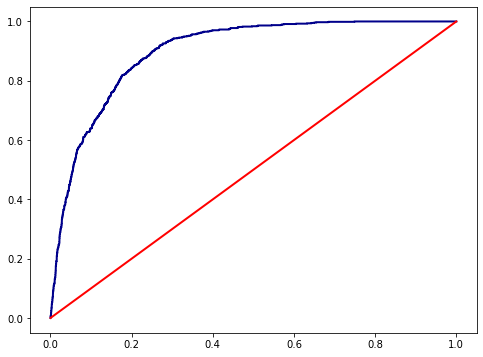

In [48]:
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_dummy, tpr_dummy, color='red', lw=2, label='Dummy Classifier (area = %0.2f)' % roc_auc)

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [49]:
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True)  # SVM with probability estimates
}

In [50]:
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")

    start_time = time.time()
    # Fit the model
    model.fit(X_train, y_train)
    end_time = time.time()
    runtime = end_time - start_time
    # Predict on the test set
    y_pred_test = model.predict(X_test)
    y_pred_prob_test = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    y_pred_train = model.predict(X_train)
    y_pred_prob_train = model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class

    # Calculate evaluation metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    train_accuracy = accuracy_score(y_train, y_pred_train)

    # Store the results
    results[model_name] = {
        'Test Accuracy': test_accuracy,
        'Train Accuracy': train_accuracy,
        'Runtime': runtime
    }

Training KNN...
Training Logistic Regression...
Training Decision Tree...
Training SVM...


In [51]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n")
print(results_df)


Model Comparison:

                     Test Accuracy  Train Accuracy     Runtime
KNN                       0.886706        0.916474    0.035695
Logistic Regression       0.880578        0.877696    0.119656
Decision Tree             0.858265        0.999175    0.078799
SVM                       0.877121        0.875850  102.151783


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [52]:

pipeline = Pipeline(steps = [("preprocessor",preprocessor),("classifier",KNeighborsClassifier())])
knn = KNeighborsClassifier()

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

grid_search_knn = GridSearchCV(pipeline, param_grid_knn, cv=5, scoring='accuracy', verbose=1)
grid_search_knn.fit(X_train, y_train)

print(f"Best Parameters for KNN: {grid_search_knn.best_params_}")
print(f"Best Score for KNN: {grid_search_knn.best_score_}")

# Example for Decision Tree
pipeline = Pipeline(steps = [("preprocessor",preprocessor),("classifier",DecisionTreeClassifier())])
dt = DecisionTreeClassifier()

param_grid_dt = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(pipeline, param_grid_dt, cv=5, scoring='accuracy', verbose=1)
grid_search_dt.fit(X_train, y_train)

print(f"Best Parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Best Score for Decision Tree: {grid_search_dt.best_score_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for KNN: {'classifier__n_neighbors': 11, 'classifier__p': 2, 'classifier__weights': 'uniform'}
Best Score for KNN: 0.8896003232330717
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Best Score for Decision Tree: 0.8885789283372676


##### Questions